In [ ]:
!pip install ultralytics torch torchvision torchaudio scikit-learn opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 71.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, glob, math, json, time, collections, random
import numpy as np
import cv2
from pathlib import Path
import torch, torch.nn as nn, torch.optim as optim
from ultralytics import YOLO
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

def make_dirs(d):
    os.makedirs(d, exist_ok=True)

def timestamp():
    return time.strftime('%Y%m%d_%H%M%S')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
class AdaptiveKeyframeExtractor:
    def __init__(self, target_frames=16):
        self.target_frames = target_frames
    def extract_frame_indices(self, video_path):
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = total_frames / fps if fps > 0 else 0
        cap.release()

        if duration > 0:
            indices = list(range(total_frames))

            # Handle case where video has no frames
            if len(indices) == 0:
                return []
            # Repeat frames to reach target
            if len(indices) < self.target_frames:
                repeat_factor = self.target_frames / len(indices)
                new_indices = []
                for i in indices:
                    n_repeats = int(np.ceil(repeat_factor))
                    new_indices.extend([i] * n_repeats)
                indices = new_indices[:self.target_frames]
        return indices[:self.target_frames]

In [ ]:
# KEYPOINT EXTRACTOR
class KeypointExtractor:

    def __init__(self, device='cpu'):
        print("Loading YOLO11 Pose model...")
        self.model = YOLO('yolo11n-pose.pt')
        self.device = device
        self.feature_dim = 51  # 17 keypoints × 3 (x, y, confidence)

    def extract(self, frame):
        """Extract keypoints from frame.

        Returns:
            np.array of shape (51,): flattened [x1,y1,conf1, x2,y2,conf2, ...]
        """
        try:
            results = self.model(frame, imgsz=640, device=self.device, verbose=False)

            if len(results) == 0 or not hasattr(results[0], 'keypoints'):
                return np.zeros(self.feature_dim, dtype=np.float32)

            kpts = results[0].keypoints

            if kpts is None or len(kpts) == 0:
                return np.zeros(self.feature_dim, dtype=np.float32)

            # Get first person's keypoints
            kpt_data = kpts.data[0].cpu().numpy()  # Shape: (17, 3)

            # Normalize coordinates by frame dimensions
            h, w = frame.shape[:2]
            kpt_data[:, 0] /= w  # Normalize x
            kpt_data[:, 1] /= h  # Normalize y

            # Flatten to 1D
            features = kpt_data.flatten()

            return features.astype(np.float32)

        except Exception as e:
            print(f"Keypoint extraction failed: {e}")
            return np.zeros(self.feature_dim, dtype=np.float32)


In [ ]:
# FEATURE CACHE
class VideoFeatureCache:

    def __init__(self, cache_dir):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(parents=True, exist_ok=True)

    def cache_path(self, video_path):
        fname = Path(video_path).stem + '.npy'
        return self.cache_dir / fname

    def exists(self, video_path):
        return self.cache_path(video_path).exists()

    def save(self, video_path, arr):
        try:
            np.save(str(self.cache_path(video_path)), arr)
        except Exception as e:
            print(f"Warning: Failed to save cache for {video_path}: {e}")

    def load(self, video_path):
        try:
            return np.load(str(self.cache_path(video_path)))
        except Exception as e:
            print(f"Warning: Failed to load cache for {video_path}: {e}")
            return None

# FEATURE EXTRACTION
def precompute_keypoint_features_adaptive(videos, extractor, cache, seq_length=16):
    """Pre-extract keypoint features"""

    print("\n" + "="*60)
    print("KEYFRAME EXTRACTION + FEATURE EXTRACTION")
    print("="*60)

    keyframe_extractor = AdaptiveKeyframeExtractor(target_frames=seq_length)
    feature_dim = extractor.feature_dim
    videos_to_process = [v for v in videos if not cache.exists(v)]

    if len(videos_to_process) == 0:
        print("All features already cached!")
        return

    print(f"Processing {len(videos_to_process)} videos...\n")

    for video_path in tqdm(videos_to_process, desc="Extracting features"):
        try:
            # Get frame indices
            frame_indices = keyframe_extractor.extract_frame_indices(video_path)

            # Extract features from selected frames
            cap = cv2.VideoCapture(video_path)
            feats = []

            for frame_idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ok, frame = cap.read()

                if not ok:
                    break

                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                feat = extractor.extract(frame) #Keypoint extraction on extracted frames
                feats.append(feat)

            cap.release()

            # Pad if needed
            if len(feats) < seq_length:
                if len(feats) == 0:
                    feats = [np.zeros(feature_dim, dtype=np.float32)] * seq_length
                else:
                    last = feats[-1]
                    while len(feats) < seq_length:
                        feats.append(last.copy())

            arr = np.stack(feats[:seq_length], axis=0).astype(np.float32)
            cache.save(video_path, arr)

        except Exception as e:
            print(f"\nError: {video_path}: {e}")
            zero_features = np.zeros((seq_length, feature_dim), dtype=np.float32)
            cache.save(video_path, zero_features)

    print("\n Feature extraction complete")

In [ ]:
class PickleballDataset(Dataset):

    def __init__(self, videos, labels, cache, seq_length=16,
                 augment=False, feature_dim=2048):
        self.videos = videos
        self.labels = labels
        self.cache = cache
        self.seq_length = seq_length
        self.augment = augment
        self.feature_dim = feature_dim

    def __len__(self):
        return len(self.videos)

    # RANDOM MASKING AUGMENTATION

    def random_keypoint_masking(self, features, mask_prob=0.15, mask_strategy='random'):
        """
        Randomly mask keypoints to simulate occlusion and improve robustness.

        Args:
            features: (seq_len, 51) array of keypoint features
            mask_prob: Probability of masking each keypoint (0.0-1.0)
            mask_strategy: 'random', 'body_part', 'temporal', or 'mixed'

        Returns:
            Masked features
        """
        features = features.copy()
        seq_len = features.shape[0]

        if mask_strategy == 'random':
            # 1: Random individual keypoint masking
            for t in range(seq_len):
                frame = features[t].reshape(17, 3)  # 17 keypoints × 3 values

                for kp_idx in range(17):
                    if random.random() < mask_prob:
                        # Mask this keypoint (set to zeros)
                        frame[kp_idx] = [0, 0, 0]

                features[t] = frame.flatten()

        elif mask_strategy == 'body_part':
            # 2: Mask entire body parts
            # Define body part groups
            body_parts = {
                'head': [0, 1, 2, 3, 4],
                'left_arm': [5, 7, 9],
                'right_arm': [6, 8, 10],
                'torso': [5, 6, 11, 12],
                'left_leg': [11, 13, 15],
                'right_leg': [12, 14, 16]
            }

            for t in range(seq_len):
                frame = features[t].reshape(17, 3)

                # Randomly mask 0-2 body parts per frame
                n_parts_to_mask = random.randint(0, 2)
                parts_to_mask = random.sample(list(body_parts.keys()), n_parts_to_mask)

                for part_name in parts_to_mask:
                    for kp_idx in body_parts[part_name]:
                        frame[kp_idx] = [0, 0, 0]

                features[t] = frame.flatten()

        elif mask_strategy == 'temporal':

            # Choose 1-3 keypoints to mask temporally
            n_keypoints = random.randint(1, 3)
            keypoints_to_mask = random.sample(range(17), n_keypoints)

            for kp_idx in keypoints_to_mask:
                # Mask for 2-5 consecutive frames
                mask_duration = random.randint(2, 5)
                start_frame = random.randint(0, max(0, seq_len - mask_duration))

                for t in range(start_frame, min(start_frame + mask_duration, seq_len)):
                    frame = features[t].reshape(17, 3)
                    frame[kp_idx] = [0, 0, 0]
                    features[t] = frame.flatten()

        elif mask_strategy == 'mixed':
            # 4: Combine all strategies with random selection
            strategy = random.choice(['random', 'body_part', 'temporal'])
            return self.random_keypoint_masking(features, mask_prob, strategy)

        return features


    def temporal_augmentation(self, features):
        """Apply temporal augmentation to feature sequence."""
        seq_len = features.shape[0]

        # Random temporal shift (±20% of sequence)
        if random.random() < 0.5:
            shift = random.randint(-seq_len // 5, seq_len // 5)
            if shift > 0:
                # Shift right: pad left, trim right
                features = np.concatenate([
                    np.repeat(features[0:1], shift, axis=0),
                    features[:-shift]
                ], axis=0)
            elif shift < 0:
                # Shift left: trim left, pad right
                features = np.concatenate([
                    features[-shift:],
                    np.repeat(features[-1:], -shift, axis=0)
                ], axis=0)

        # Random temporal dropout (drop 1-2 frames, duplicate neighbors)
        if random.random() < 0.3:
            num_drops = random.randint(1, 2)
            for _ in range(num_drops):
                drop_idx = random.randint(1, seq_len - 2)
                # Replace dropped frame with average of neighbors
                features[drop_idx] = (features[drop_idx-1] + features[drop_idx+1]) / 2

        # Random temporal reverse (for symmetric actions)
        if random.random() < 0.2:
            features = features[::-1].copy()

        return features

    def add_feature_noise(self, x, std=0.01):
        noise = np.random.normal(0, std, x.shape).astype(np.float32)
        return x + noise

    def frame_dropout(self, x, max_drops=3):
        L = x.shape[0]
        drops = random.randint(1, max_drops)
        idxs = np.random.choice(L, drops, replace=False)
        x[idxs] = 0
        return x

    def __getitem__(self, idx):
        v = self.videos[idx]

        # Load from cache
        x = self.cache.load(v)

        if x is None:
            # Fallback: return zeros if cache missing
            print(f"Warning: Cache missing for {v}, using zeros")
            x = np.zeros((self.seq_length, self.feature_dim), dtype=np.float32)

        # Apply augmentation during training

        if random.random() < 0.5:
            mask_strategy = random.choice(['random', 'body_part', 'temporal', 'mixed'])
            mask_prob = random.uniform(0.1, 0.2)  # 10-20% masking
            x = self.random_keypoint_masking(x, mask_prob, mask_strategy)

        if self.augment:
            x = self.temporal_augmentation(x)

        if self.augment and random.random() < 0.5:
            x = self.add_feature_noise(x, std=0.02)

        if self.augment and random.random() < 0.3:
            x = self.frame_dropout(x)


        y = int(self.labels[idx])
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)



Using device: cuda

Loading TRAIN data...
Train: {'DriveBackhand': 400, 'DriveForehand': 400, 'Smash': 400, 'Volley': 400}

Loading VALIDATION data...
Validation: {'DriveBackhand': 140, 'DriveForehand': 140, 'Smash': 140, 'Volley': 140}

Loading TEST data...
Test: {'DriveBackhand': 130, 'DriveForehand': 130, 'Smash': 130, 'Volley': 130}
Loading YOLO11 Pose model...

KEYFRAME EXTRACTION + FEATURE EXTRACTION
All features already cached!

KEYFRAME EXTRACTION + FEATURE EXTRACTION
All features already cached!

KEYFRAME EXTRACTION + FEATURE EXTRACTION
All features already cached!

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.4453 | Acc: 24.75%
Val   Loss: 1.4253 | Acc: 22.14%
 Saved best model

Epoch 2/100


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.3838 | Acc: 31.25%
Val   Loss: 1.4151 | Acc: 25.36%
 Saved best model

Epoch 3/100


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.3627 | Acc: 32.56%
Val   Loss: 1.4074 | Acc: 26.25%
 Saved best model

Epoch 4/100


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.3134 | Acc: 35.12%
Val   Loss: 1.4389 | Acc: 27.32%

Epoch 5/100


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.2892 | Acc: 37.69%
Val   Loss: 1.3992 | Acc: 25.36%
 Saved best model

Epoch 6/100


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.3022 | Acc: 35.62%
Val   Loss: 1.4155 | Acc: 25.36%

Epoch 7/100


Train Loss: 1.2597 | Acc: 39.56%
Val   Loss: 1.4580 | Acc: 24.64%

Epoch 8/100


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.2619 | Acc: 39.25%
Val   Loss: 1.5148 | Acc: 28.75%

Epoch 9/100


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.2343 | Acc: 42.81%
Val   Loss: 1.4688 | Acc: 33.93%

Epoch 10/100


Train Loss: 1.2430 | Acc: 41.75%
Val   Loss: 1.4051 | Acc: 30.18%

Epoch 11/100


Train Loss: 1.1874 | Acc: 45.88%
Val   Loss: 1.5005 | Acc: 30.36%

Epoch 12/100


Train Loss: 1.1269 | Acc: 49.88%
Val   Loss: 1.2731 | Acc: 37.68%
 Saved best model

Epoch 13/100


Train Loss: 1.1521 | Acc: 50.44%
Val   Loss: 1.3094 | Acc: 38.04%

Epoch 14/100


Train Loss: 1.0942 | Acc: 54.50%
Val   Loss: 1.2308 | Acc: 46.25%
 Saved best model

Epoch 15/100


Train Loss: 1.0788 | Acc: 55.62%
Val   Loss: 1.3546 | Acc: 43.93%

Epoch 16/100


Train Loss: 1.0836 | Acc: 54.19%
Val   Loss: 1.3194 | Acc: 47.50%

Epoch 17/100


Train Loss: 1.0726 | Acc: 58.25%
Val   Loss: 1.2269 | Acc: 45.89%
 Saved best model

Epoch 18/100


Train Loss: 0.9985 | Acc: 61.56%
Val   Loss: 1.1112 | Acc: 53.04%
 Saved best model

Epoch 19/100


Train Loss: 1.0399 | Acc: 58.19%
Val   Loss: 1.1497 | Acc: 51.07%

Epoch 20/100


Train Loss: 1.0141 | Acc: 61.31%
Val   Loss: 1.2175 | Acc: 48.04%

Epoch 21/100


Train Loss: 1.0292 | Acc: 59.94%
Val   Loss: 1.1960 | Acc: 53.21%

Epoch 22/100


Train Loss: 0.9738 | Acc: 63.31%
Val   Loss: 1.0702 | Acc: 62.50%
 Saved best model

Epoch 23/100


Train Loss: 0.9522 | Acc: 64.44%
Val   Loss: 1.2123 | Acc: 49.29%

Epoch 24/100


Train Loss: 0.9356 | Acc: 66.56%
Val   Loss: 1.1898 | Acc: 55.36%

Epoch 25/100


Train Loss: 0.9025 | Acc: 67.56%
Val   Loss: 1.1970 | Acc: 57.14%

Epoch 26/100


Train Loss: 0.9436 | Acc: 65.38%
Val   Loss: 1.0088 | Acc: 63.04%
 Saved best model

Epoch 27/100


Train Loss: 0.9041 | Acc: 68.12%
Val   Loss: 1.2004 | Acc: 51.96%

Epoch 28/100


Train Loss: 0.9237 | Acc: 66.31%
Val   Loss: 1.0472 | Acc: 63.93%

Epoch 29/100


Train Loss: 0.8811 | Acc: 68.88%
Val   Loss: 1.0766 | Acc: 62.14%

Epoch 30/100


Train Loss: 0.8848 | Acc: 68.75%
Val   Loss: 1.3161 | Acc: 55.36%

Epoch 31/100


Train Loss: 0.8763 | Acc: 70.25%
Val   Loss: 1.1486 | Acc: 58.75%

Epoch 32/100


Train Loss: 0.8617 | Acc: 69.50%
Val   Loss: 0.9617 | Acc: 68.93%
 Saved best model

Epoch 33/100


Train Loss: 0.8334 | Acc: 72.56%
Val   Loss: 1.0429 | Acc: 66.43%

Epoch 34/100


Train Loss: 0.8606 | Acc: 70.69%
Val   Loss: 1.1644 | Acc: 56.61%

Epoch 35/100


Train Loss: 0.8281 | Acc: 71.25%
Val   Loss: 1.0967 | Acc: 63.39%

Epoch 36/100


Train Loss: 0.8102 | Acc: 73.81%
Val   Loss: 1.0683 | Acc: 63.39%

Epoch 37/100


Train Loss: 0.8122 | Acc: 73.88%
Val   Loss: 0.9096 | Acc: 75.00%
 Saved best model

Epoch 38/100


Train Loss: 0.8296 | Acc: 72.69%
Val   Loss: 0.8974 | Acc: 72.68%
 Saved best model

Epoch 39/100


Train Loss: 0.7913 | Acc: 75.25%
Val   Loss: 1.1041 | Acc: 66.61%

Epoch 40/100


Train Loss: 0.7835 | Acc: 75.06%
Val   Loss: 0.9152 | Acc: 69.64%

Epoch 41/100


Train Loss: 0.7654 | Acc: 77.62%
Val   Loss: 0.9451 | Acc: 71.61%

Epoch 42/100


Train Loss: 0.7528 | Acc: 77.12%
Val   Loss: 0.9415 | Acc: 68.93%

Epoch 43/100


Train Loss: 0.7729 | Acc: 75.56%
Val   Loss: 1.0197 | Acc: 68.93%

Epoch 44/100


Train Loss: 0.8183 | Acc: 75.06%
Val   Loss: 1.0193 | Acc: 67.50%

Epoch 45/100


Train Loss: 0.7466 | Acc: 77.50%
Val   Loss: 0.9349 | Acc: 70.54%

Epoch 46/100


Train Loss: 0.7521 | Acc: 77.12%
Val   Loss: 0.8652 | Acc: 75.71%
 Saved best model

Epoch 47/100


Train Loss: 0.7161 | Acc: 79.50%
Val   Loss: 0.8827 | Acc: 72.32%

Epoch 48/100


Train Loss: 0.7450 | Acc: 77.88%
Val   Loss: 0.9190 | Acc: 71.79%

Epoch 49/100


Train Loss: 0.7262 | Acc: 79.12%
Val   Loss: 0.8263 | Acc: 79.46%
 Saved best model

Epoch 50/100


Train Loss: 0.7079 | Acc: 80.50%
Val   Loss: 1.1393 | Acc: 62.14%

Epoch 51/100


Train Loss: 0.7093 | Acc: 79.69%
Val   Loss: 0.8453 | Acc: 71.79%

Epoch 52/100


Train Loss: 0.7296 | Acc: 79.00%
Val   Loss: 1.0405 | Acc: 67.86%

Epoch 53/100


Train Loss: 0.7140 | Acc: 79.19%
Val   Loss: 0.8411 | Acc: 77.50%

Epoch 54/100


Train Loss: 0.7295 | Acc: 79.62%
Val   Loss: 1.1268 | Acc: 65.36%

Epoch 55/100


Train Loss: 0.7078 | Acc: 80.88%
Val   Loss: 0.9227 | Acc: 72.50%

Epoch 56/100


Train Loss: 0.6892 | Acc: 81.38%
Val   Loss: 0.9093 | Acc: 73.57%

Epoch 57/100


Train Loss: 0.7247 | Acc: 79.50%
Val   Loss: 0.9684 | Acc: 70.00%

Epoch 58/100


Train Loss: 0.6707 | Acc: 82.00%
Val   Loss: 0.8544 | Acc: 76.96%

Epoch 59/100


Train Loss: 0.6824 | Acc: 83.31%
Val   Loss: 0.8740 | Acc: 76.25%

Epoch 60/100


Train Loss: 0.6869 | Acc: 82.19%
Val   Loss: 1.0379 | Acc: 68.04%

Epoch 61/100


Train Loss: 0.6784 | Acc: 82.12%
Val   Loss: 1.0566 | Acc: 66.43%

Epoch 62/100


Train Loss: 0.7038 | Acc: 80.88%
Val   Loss: 0.9721 | Acc: 71.61%

Epoch 63/100


Train Loss: 0.6241 | Acc: 84.50%
Val   Loss: 0.8154 | Acc: 80.00%
 Saved best model

Epoch 64/100


Train Loss: 0.6607 | Acc: 83.56%
Val   Loss: 0.8330 | Acc: 79.29%

Epoch 65/100


Train Loss: 0.6450 | Acc: 84.12%
Val   Loss: 0.8504 | Acc: 79.46%

Epoch 66/100


Train Loss: 0.6601 | Acc: 83.50%
Val   Loss: 0.8987 | Acc: 75.89%

Epoch 67/100


Train Loss: 0.6775 | Acc: 83.12%
Val   Loss: 0.7828 | Acc: 82.14%
 Saved best model

Epoch 68/100


Train Loss: 0.6365 | Acc: 84.88%
Val   Loss: 0.8529 | Acc: 77.14%

Epoch 69/100


Train Loss: 0.6592 | Acc: 83.88%
Val   Loss: 0.8558 | Acc: 76.96%

Epoch 70/100


Train Loss: 0.6371 | Acc: 84.50%
Val   Loss: 0.8212 | Acc: 79.46%

Epoch 71/100


Train Loss: 0.6258 | Acc: 85.81%
Val   Loss: 0.8285 | Acc: 79.46%

Epoch 72/100


Train Loss: 0.6183 | Acc: 86.81%
Val   Loss: 0.7997 | Acc: 80.71%

Epoch 73/100


Train Loss: 0.6097 | Acc: 85.62%
Val   Loss: 0.8494 | Acc: 77.32%

Epoch 74/100


Train Loss: 0.6357 | Acc: 84.50%
Val   Loss: 0.8326 | Acc: 79.29%

Epoch 75/100


Train Loss: 0.6643 | Acc: 83.06%
Val   Loss: 0.9504 | Acc: 74.64%

Epoch 76/100


Train Loss: 0.6103 | Acc: 86.50%
Val   Loss: 0.8690 | Acc: 78.21%

Epoch 77/100


Train Loss: 0.5995 | Acc: 87.06%
Val   Loss: 0.8026 | Acc: 79.64%

Epoch 78/100


Train Loss: 0.6508 | Acc: 84.50%
Val   Loss: 1.0402 | Acc: 66.61%

Epoch 79/100


Train Loss: 0.6103 | Acc: 85.94%
Val   Loss: 0.7427 | Acc: 82.86%
 Saved best model

Epoch 80/100


Train Loss: 0.6048 | Acc: 87.00%
Val   Loss: 0.8479 | Acc: 78.21%

Epoch 81/100


Train Loss: 0.6071 | Acc: 86.38%
Val   Loss: 0.7239 | Acc: 83.04%
 Saved best model

Epoch 82/100


Train Loss: 0.5892 | Acc: 88.25%
Val   Loss: 0.7794 | Acc: 81.79%

Epoch 83/100


Train Loss: 0.6060 | Acc: 86.00%
Val   Loss: 0.7959 | Acc: 79.82%

Epoch 84/100


Train Loss: 0.5885 | Acc: 87.69%
Val   Loss: 0.8325 | Acc: 77.86%

Epoch 85/100


Train Loss: 0.5867 | Acc: 87.31%
Val   Loss: 0.8295 | Acc: 78.57%

Epoch 86/100


Train Loss: 0.5580 | Acc: 89.19%
Val   Loss: 0.7799 | Acc: 82.32%

Epoch 87/100


Train Loss: 0.5883 | Acc: 87.56%
Val   Loss: 0.7457 | Acc: 82.50%

Epoch 88/100


Train Loss: 0.5873 | Acc: 86.94%
Val   Loss: 0.9071 | Acc: 75.00%

Epoch 89/100


Train Loss: 0.6076 | Acc: 86.19%
Val   Loss: 0.8994 | Acc: 76.25%

Epoch 90/100


Train Loss: 0.5794 | Acc: 87.81%
Val   Loss: 0.8030 | Acc: 81.07%

Epoch 91/100


Train Loss: 0.5629 | Acc: 88.88%
Val   Loss: 0.7531 | Acc: 82.14%

Epoch 92/100


Train Loss: 0.5603 | Acc: 88.75%
Val   Loss: 0.8092 | Acc: 80.89%

Epoch 93/100


Train Loss: 0.6198 | Acc: 86.12%
Val   Loss: 0.8710 | Acc: 75.71%

Epoch 94/100


Train Loss: 0.5872 | Acc: 87.62%
Val   Loss: 0.7490 | Acc: 83.39%

Epoch 95/100


Train Loss: 0.5886 | Acc: 86.88%
Val   Loss: 0.8219 | Acc: 78.75%

Epoch 96/100


Train Loss: 0.5712 | Acc: 88.19%
Val   Loss: 0.7971 | Acc: 85.36%

Epoch 97/100


Train Loss: 0.5616 | Acc: 89.00%
Val   Loss: 0.8051 | Acc: 82.32%

Epoch 98/100


Train Loss: 0.5787 | Acc: 87.88%
Val   Loss: 0.7105 | Acc: 83.04%
 Saved best model

Epoch 99/100


Train Loss: 0.5897 | Acc: 87.44%
Val   Loss: 0.7674 | Acc: 80.00%

Epoch 100/100


Train Loss: 0.5969 | Acc: 86.75%
Val   Loss: 0.8702 | Acc: 77.32%

TEST RESULT
               precision    recall  f1-score   support

DriveBackhand       0.38      0.51      0.43       130
DriveForehand       0.47      0.31      0.37       130
        Smash       0.43      0.77      0.56       130
       Volley       0.23      0.05      0.09       130

     accuracy                           0.41       520
    macro avg       0.38      0.41      0.36       520
 weighted avg       0.38      0.41      0.36       520


BEST ACCURACY SUMMARY
Best Train Accuracy      : 89.19%
Best Validation Accuracy : 85.36%
Test Accuracy            : 40.96%
Confusion Matrix:
 [[ 66  16  39   9]
 [ 37  40  49   4]
 [ 12   7 100  11]
 [ 59  22  42   7]]


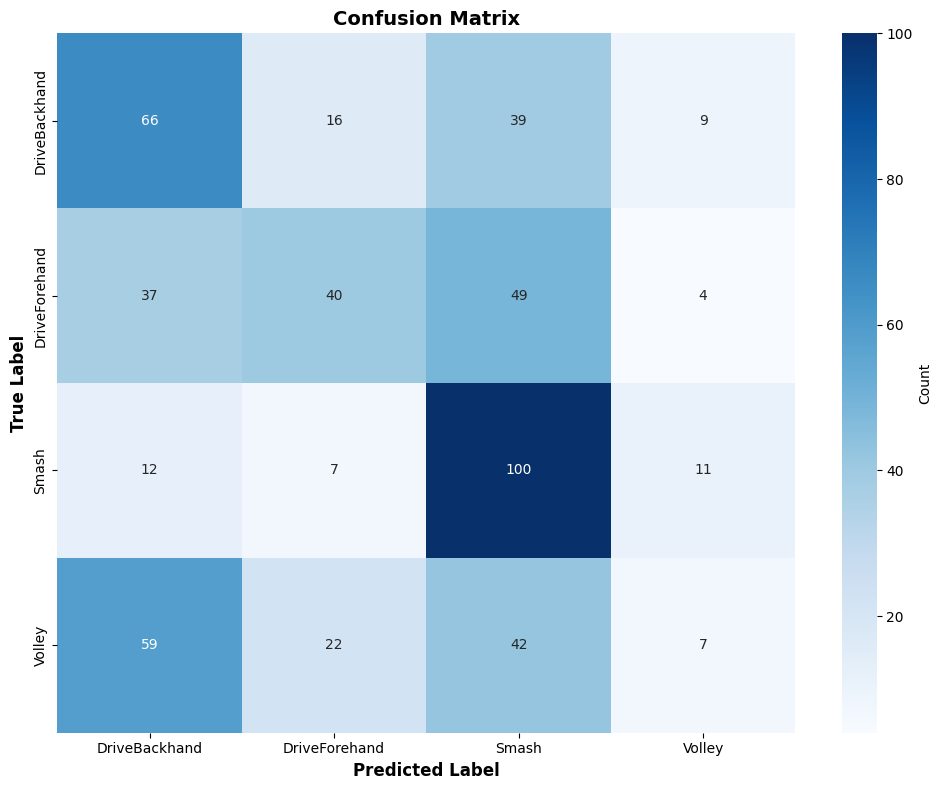

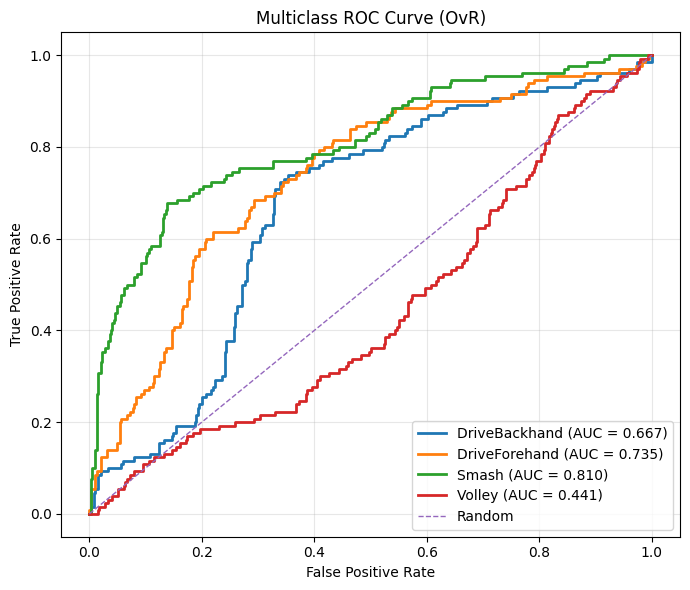

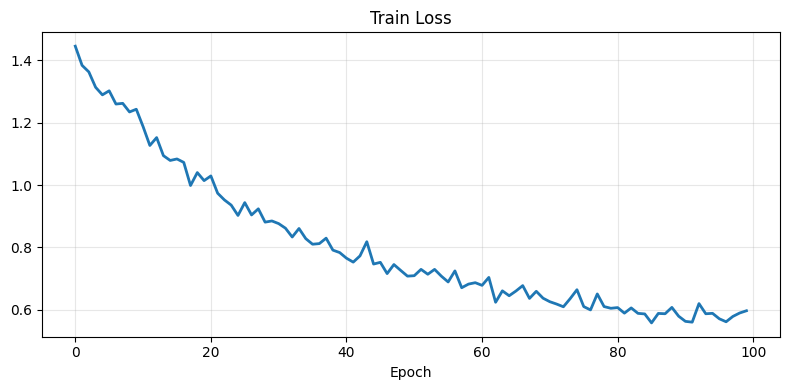

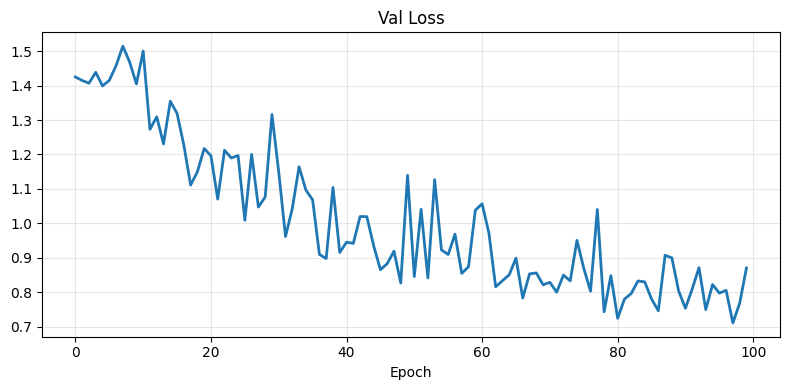

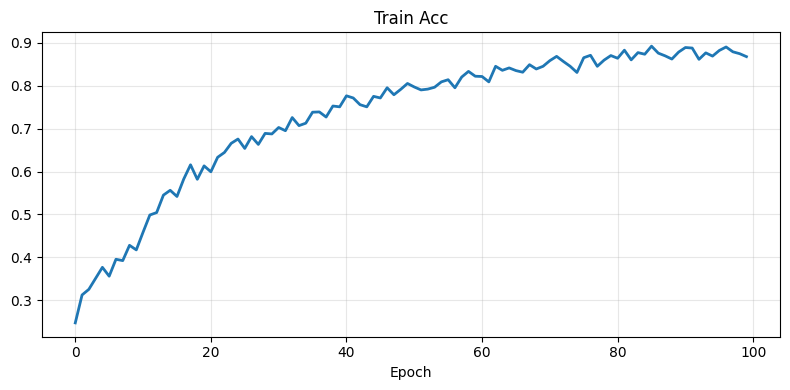

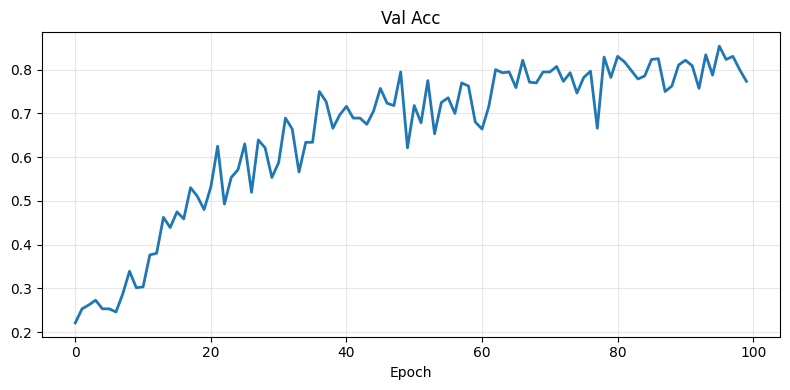

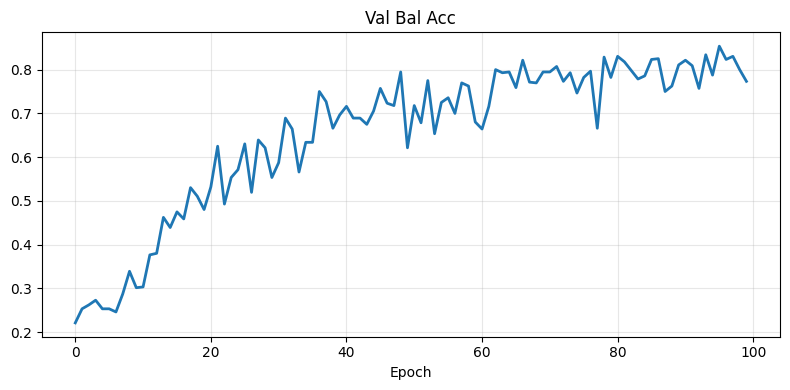

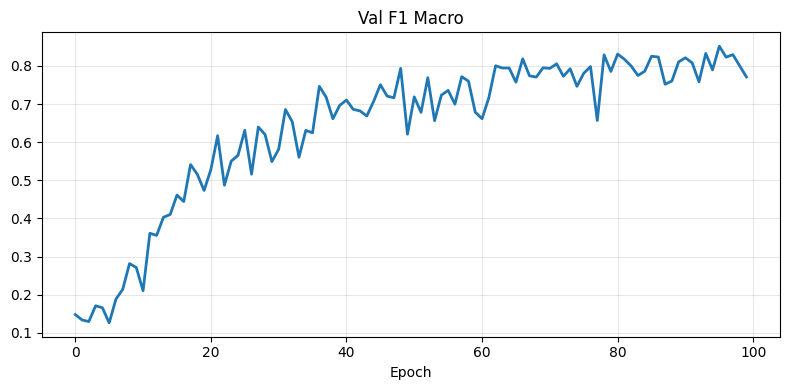

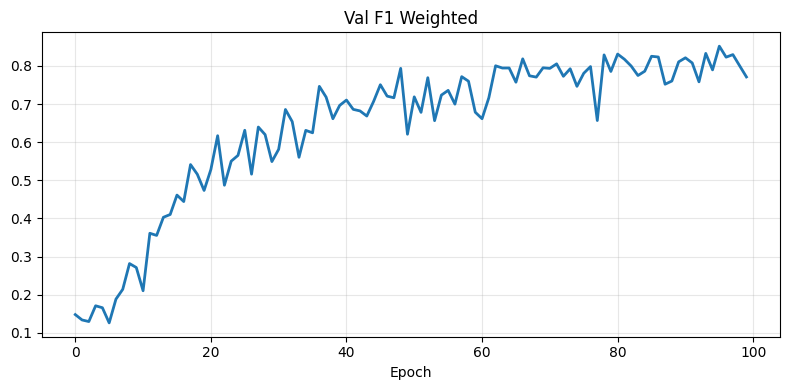

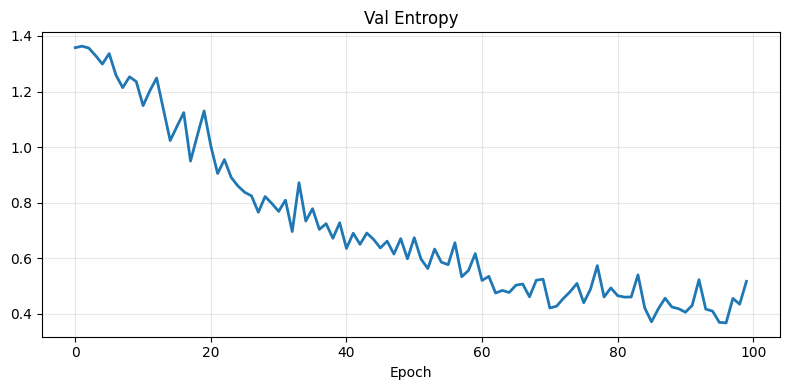

In [ ]:
import os, glob, math, json, time, collections, random
import numpy as np
import cv2
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, balanced_accuracy_score, roc_auc_score, log_loss, roc_curve

# UTILS
def make_dirs(d):
    os.makedirs(d, exist_ok=True)

def timestamp():
    return time.strftime('%Y%m%d_%H%M%S')
# FIX RANDOM SEED
def set_seed(seed=42):
    import random
    import numpy as np
    import torch

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Make CUDA deterministic (may slightly reduce speed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# LSTM MODEL
class KeypointLSTMClassifier(nn.Module):
    def __init__(self, feature_dim=51, hidden=128, num_layers=1,
                 num_classes=2, dropout=0.3):
        super().__init__()

        self.lstm = nn.LSTM(
            feature_dim,
            hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(hidden)
        self.classifier = nn.Linear(hidden, num_classes)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        h = h[-1]
        h = self.dropout(h)
        h = self.ln(h)
        return self.classifier(h)

# EARLY STOPPING
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
            return False

        improved = (
            score < self.best_score - self.min_delta
            if self.mode == 'min'
            else score > self.best_score + self.min_delta
        )

        if improved:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

# DATA LOADING
def list_videos(root, classes):
    vids, labels, counts = [], [], {}

    for ci, cname in enumerate(classes):
        p = Path(root) / cname
        if not p.exists():
            print(f"Warning: {p} does not exist")
            counts[cname] = 0
            continue

        files = (
            list(p.glob('*.mp4')) +
            list(p.glob('*.avi')) +
            list(p.glob('*.MOV'))
        )

        vids.extend([str(f) for f in files])
        labels.extend([ci] * len(files))
        counts[cname] = len(files)

    return vids, labels, counts
# PLOTTING
def plot_training_history(history):
    for key in ['train_loss', 'val_loss', 'train_acc', 'val_acc', 'val_bal_acc', 'val_f1_macro', 'val_f1_weighted', 'val_entropy']:
        plt.figure(figsize=(8, 4))
        plt.plot(history[key], linewidth=2)
        plt.title(key.replace('_', ' ').title())
        plt.xlabel("Epoch")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

def plot_confusion_matrix(cm, classes):
    import seaborn as sns

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Count'}, ax=ax)

    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()
from sklearn.preprocessing import label_binarize

def plot_roc_curve(labels, probs, class_names):
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))

    plt.figure(figsize=(7, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
        auc_score = roc_auc_score(
            labels_bin[:, i],
            probs[:, i]
        )

        plt.plot(
            fpr, tpr, linewidth=2,
            label=f"{class_names[i]} (AUC = {auc_score:.3f})"
        )

    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1, label="Random")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve (OvR)")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# TRAINING FUNCTION

def train_adaptive_model(params):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"\nUsing device: {device}")

    # LOAD DATA
    print("\nLoading TRAIN data...")
    train_vids, train_labels, train_counts = list_videos(
        params['train_data_root'], params['classes']
    )
    print("Train:", train_counts)

    print("\nLoading VALIDATION data...")
    val_vids, val_labels, val_counts = list_videos(
        params['val_data_root'], params['classes']
    )
    print("Validation:", val_counts)

    print("\nLoading TEST data...")
    test_vids, test_labels, test_counts = list_videos(
        params['test_data_root'], params['classes']
    )
    print("Test:", test_counts)

    # FEATURE EXTRACTION (CACHED)
    extractor = KeypointExtractor(device=device)
    train_cache = VideoFeatureCache(params['train_cache_dir'])
    val_cache   = VideoFeatureCache(params['val_cache_dir'])
    test_cache  = VideoFeatureCache(params['test_cache_dir'])


    precompute_keypoint_features_adaptive(
        train_vids, extractor, train_cache,
        seq_length=params['seq_length']
    )

    precompute_keypoint_features_adaptive(
        val_vids, extractor, val_cache,
        seq_length=params['seq_length']
    )

    precompute_keypoint_features_adaptive(
        test_vids, extractor, test_cache,
        seq_length=params['seq_length']
    )

    del extractor
    if device == 'cuda':
        torch.cuda.empty_cache()


    # DATASETS & LOADERS
    train_ds = PickleballDataset(
        train_vids, train_labels, train_cache,
        seq_length=params['seq_length'],
        augment=True, feature_dim=51
    )

    val_ds = PickleballDataset(
        val_vids, val_labels, val_cache,
        seq_length=params['seq_length'],
        augment=False, feature_dim=51
    )

    test_ds = PickleballDataset(
        test_vids, test_labels, test_cache,
        seq_length=params['seq_length'],
        augment=False, feature_dim=51
    )

    train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=params['batch_size'], shuffle=False)

    # MODEL
    model = KeypointLSTMClassifier(
        feature_dim=51,
        hidden=params['hidden_size'],
        num_layers=params['num_layers'],
        num_classes=len(params['classes']),
        dropout=params['dropout_rate']
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=0.01)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    early_stopping = EarlyStopping(patience=20)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_bal_acc': [], 'val_f1_macro': [], 'val_f1_weighted': [], 'val_entropy': []}
    best_val_loss = float('inf')
    best_train_acc = 0.0
    best_val_acc   = 0.0

    # TRAIN LOOP
    for epoch in range(params['epochs']):
        print(f"\nEpoch {epoch+1}/{params['epochs']}")

        model.train()
        total_loss, correct, total = 0, 0, 0

        for X, y in tqdm(train_loader, desc="Training", leave=False):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        best_train_acc = max(best_train_acc, train_acc)

        model.eval()
        val_loss, correct, total = 0, 0, 0
        val_preds, val_labels, val_probs = [], [], []

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)

                prob = torch.softmax(out, dim=1)

                loss = criterion(out, y)
                val_loss += loss.item()
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)

                val_preds.extend(out.argmax(1).cpu().numpy())
                val_labels.extend(y.cpu().numpy())
                val_probs.extend(prob.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = correct / total
        best_val_acc   = max(best_val_acc, val_acc)


        val_preds = np.array(val_preds)
        val_labels = np.array(val_labels)
        val_probs = np.array(val_probs)

        val_bal_acc = balanced_accuracy_score(val_labels, val_preds)

        _, _, val_f1_macro, _ = precision_recall_fscore_support(
            val_labels, val_preds, average='macro'
        )

        _, _, val_f1_weighted, _ = precision_recall_fscore_support(
            val_labels, val_preds, average='weighted'
        )

        entropy = -np.sum(val_probs * np.log(val_probs + 1e-8), axis=1)
        val_entropy = entropy.mean()



        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_bal_acc'].append(val_bal_acc)
        history['val_f1_macro'].append(val_f1_macro)
        history['val_f1_weighted'].append(val_f1_weighted)
        history['val_entropy'].append(val_entropy)


        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}%")
        print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc*100:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), params['out_dir'] + '/best_model.pth')
            print(" Saved best model")

        if early_stopping(val_loss):
            print(" Early stopping")
            break

    # TEST
    model.load_state_dict(torch.load(params['out_dir'] + '/best_model.pth'))
    model.eval()

    test_preds, test_labels = [], []
    test_probs = []


    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            prob = torch.softmax(out, dim=1)

            test_preds.extend(out.argmax(1).cpu().numpy())
            test_labels.extend(y.cpu().numpy())
            test_probs.extend(prob.cpu().numpy())


    labels = np.array(test_labels)
    preds  = np.array(test_preds)
    probs  = np.array(test_probs)
    if labels.ndim > 1:
        labels = labels.argmax(axis=1)

    test_acc = (preds == labels).mean()




    print("\nTEST RESULT")
    print(classification_report(labels, preds, target_names=params['classes']))
    print("\nBEST ACCURACY SUMMARY")
    print(f"Best Train Accuracy      : {best_train_acc * 100:.2f}%")
    print(f"Best Validation Accuracy : {best_val_acc * 100:.2f}%")
    print(f"Test Accuracy            : {test_acc * 100:.2f}%")

    #More metrics
    # Precision / Recall / F1
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, preds, average='macro'
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )
    # ROC-AUC (One-vs-Rest)
    roc_auc = roc_auc_score(labels, probs, multi_class='ovr', average='macro')


    # Log Loss
    test_log_loss = log_loss(labels, probs)
    # Prediction Entropy (Uncertainty)
    entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
    mean_entropy = entropy.mean()

    cm = confusion_matrix(labels, preds)
    print("Confusion Matrix:\n", cm)
    plot_confusion_matrix(cm, params['classes'])
    plot_roc_curve(labels, probs, params['classes'])
    plot_training_history(history)

    return model, history

if __name__ == '__main__':
    set_seed(42)

    params = {
    'train_data_root': '/content/drive/MyDrive/DatasetVideoPickle',
    'val_data_root': '/content/drive/MyDrive/DatasetVideoPickle/VideoValTest/Validation',
    'test_data_root': '/content/drive/MyDrive/DatasetVideoPickle/VideoValTest/Test',

    'classes': ['DriveBackhand', 'DriveForehand', 'Smash', 'Volley'],
    'seq_length': 16,
    #Sửa từ đây
    'batch_size': 16,
    'lr': 0.001,
    'epochs': 100,
    'hidden_size': 128,
    'dropout_rate': 0.4,
    'num_layers': 2,

    'out_dir': '/content/drive/MyDrive/keypoint_experiments_4dongtac',
    'train_cache_dir': '/content/drive/MyDrive/cache_train_4dongtac',
    'val_cache_dir':   '/content/drive/MyDrive/cache_val_4dongtac',
    'test_cache_dir':  '/content/drive/MyDrive/cache_test_4dongtac',
}


    make_dirs(params['out_dir'])
    make_dirs(params['train_cache_dir'])
    make_dirs(params['val_cache_dir'])
    make_dirs(params['test_cache_dir'])

    model, history = train_adaptive_model(params)
